In [127]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

In [128]:
df = pd.read_csv("/Users/r3alistic/Programming/CoffeeCV/features_v2.csv")
df.head()

,onset_time_s,continuity,mean_width,cv_width,amp_width,slope_width,jitter_cx,delta_val,delta_hue,flicker,label_rule_based,pull_duration_s,true_label,frame_folder
0,0.033333,0.992823,38.191387,0.271673,49.0,0.059983,154.437988,25.0,5.5,6.0,underextracted,30.72,good,frames_good_pulls/vid_100_good
1,0.033333,0.997608,24.657894,0.338018,32.0,-0.009234,155.832611,29.0,6.0,2.0,underextracted,30.05,good,frames_good_pulls/vid_102_good
2,0.016667,0.997613,36.463009,0.250612,44.0,0.015607,172.412918,26.0,5.0,2.0,underextracted,29.32,good,frames_good_pulls/vid_105_good
3,0.016667,0.985680,21.544153,0.241984,27.0,-0.023103,169.787109,22.0,5.0,12.0,underextracted,30.02,good,frames_good_pulls/vid_108_good
4,0.016667,0.894988,19.821003,0.319346,34.0,-0.025514,70.975861,9.0,2.5,79.0,underextracted,27.55,good,frames_good_pulls/vid_112_good


In [129]:
df = df[df["frame_folder"]!="frames_under_pulls/vid_138_under"]

In [130]:
df.shape

(157, 14)

In [131]:
df["true_label"].value_counts()

true_label
good     95
under    62
Name: count, dtype: int64

Right now there are no missing values, but just drop them if there are.

In [132]:
df.dropna(axis=0,inplace=True)

In [133]:
df.isna().sum().sum()

0

Now just for sanity, check for duplicates

In [134]:
len(df["frame_folder"]) == len(set(df["frame_folder"]))

True

# Summary Statistics

In [135]:
df.describe()

,onset_time_s,continuity,mean_width,cv_width,amp_width,slope_width,jitter_cx,delta_val,delta_hue,flicker,pull_duration_s
count,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000
mean,0.044798,0.877084,27.865137,0.561888,55.216561,-0.035462,120.175406,4.102707,2.366242,27.687898,28.550573
std,0.164925,0.225466,18.683994,0.840507,40.410762,0.058051,62.273917,20.307519,2.176051,38.969392,5.378337
min,0.016667,0.004773,0.210024,0.147891,13.000000,-0.311933,1.519082,-53.000000,-1.000000,0.000000,8.640000
25%,0.016667,0.875895,17.198565,0.271405,33.000000,-0.046667,75.793739,-8.750000,1.000000,0.000000,27.020000
50%,0.016667,0.980907,25.775656,0.329299,44.000000,-0.023004,121.578384,3.000000,2.000000,8.000000,29.770000
75%,0.016667,1.000000,33.887020,0.544255,58.000000,-0.002801,151.075668,16.000000,4.000000,43.000000,31.500000
max,1.866667,1.000000,120.109787,8.436661,252.000000,0.085365,327.269501,61.000000,8.500000,169.000000,46.540000


In [136]:
def aggregate_mean(df,features):
    return df.groupby(by=["true_label"])[features].mean()

def aggregate_median(df,features):
    return df.groupby(by=["true_label"])[features].median()

In [137]:
aggregate_mean(df,["continuity","delta_val","jitter_cx","delta_hue","delta_val","pull_duration_s"])

,continuity,delta_val,jitter_cx,delta_hue,delta_val,pull_duration_s
true_label,,,,,,
good,0.916539,7.515789,132.797746,3.221053,7.515789,28.493789
under,0.816629,-1.127016,100.834722,1.056452,-1.127016,28.637581


What do these tell me? The good thing is that if we are looking at the mean, then our numeric features have a stark contrast. However, there are way less underextracted than good videos, so let's check median

In [138]:
aggregate_median(df,["continuity","delta_val","jitter_cx","delta_hue","delta_val","pull_duration_s"])

,continuity,delta_val,jitter_cx,delta_hue,delta_val,pull_duration_s
true_label,,,,,,
good,0.985680,6.0,127.807686,3.0,6.0,29.700
under,0.965394,1.5,94.851383,1.0,1.5,30.155


Out of all of these, continuity and pull duration might not be worthy features

# Data Preprocessing + Model Building --> Pipeline

(Even with an abysmally low amount of data)

In [139]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

First we will try <u>Logistic Regression</u>

In [140]:
# Separate features and target
X = df.drop(columns=["true_label", "label_rule_based","frame_folder"])
y = df["true_label"].to_numpy()

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

predictors_num = list(X.columns)

# preprocessor = ColumnTransformer([
#     ("scaler",StandardScaler(),predictors_num),
# ],remainder="drop") #keep "drop". This column transformer will only affect X

# Encode target labels as integers (ex: good = 0, under = 1). OneHotEncoder would be too much here. Just labels in the same column is fine
#pipeline .fit and .predict calls know to do fit_transform on train data and just .transform on test data and unseen data

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42,stratify=y_encoded)

#Using a pipeline no matter what. When we save the best one with joblib, it will have all the preprocessing built into it.
pipeline_1 = Pipeline([
    ("imputer",SimpleImputer(strategy="median")), #just in case
    ("scaler",StandardScaler()),
    ("classifier",LogisticRegression(class_weight='balanced',max_iter=1000))
])

#y_test is encoded for future reference testing
pipeline_1.fit(X_train,y_train)

,steps,"[('imputer', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


For now, leave that test set completely unseen. We are working with Logistic Regression right now. Just validate 

In [141]:
# label mapping for later
label_map = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(label_map)  # e.g., {'good':0, 'under':1}

{'good': 0, 'under': 1}


# Validation Strategies

In [142]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, roc_auc_score, average_precision_score

In [143]:
def print_scores(model,type):

    if type=="test":
        proba = model.predict_proba(X_test)[:,1] # the [:,1] means get all rows of column 1, which corresponds to under
        pred  = (proba >= 0.5).astype(int) #we can choose the threshold

        print("TEST ROC-AUC:", roc_auc_score(y_test, proba))
        print("TEST PR-AUC :", average_precision_score(y_test, proba))

        cm = confusion_matrix(y_test, pred)

        print(classification_report(y_test, pred, target_names=encoder.classes_))
        print("TEST accuracy",accuracy_score(y_test,pred))

    else:
        proba = model.predict_proba(X_train)[:,1]
        pred  = (proba >= 0.5).astype(int) #we can choose the threshold

        print("TRAIN ROC-AUC:", roc_auc_score(y_train, proba))
        print("TRAIN PR-AUC :", average_precision_score(y_train, proba))
        
        cm = confusion_matrix(y_train, pred)

        print(classification_report(y_train, pred, target_names=encoder.classes_))
        print("TRAIN accuracy",accuracy_score(y_train,pred))

    plt.figure(figsize=(4,3))
    sns.heatmap(cm,annot=True,cmap="viridis",cbar=False,xticklabels=encoder.classes_,yticklabels=encoder.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Pred")
    plt.ylabel("Actual")
    plt.show()

## Training Scores - Model 1

TRAIN ROC-AUC: 0.9078947368421053
TRAIN PR-AUC : 0.8835629501102842
              precision    recall  f1-score   support

        good       0.87      0.79      0.83        76
       under       0.71      0.82      0.76        49

    accuracy                           0.80       125
   macro avg       0.79      0.80      0.79       125
weighted avg       0.81      0.80      0.80       125

TRAIN accuracy 0.8


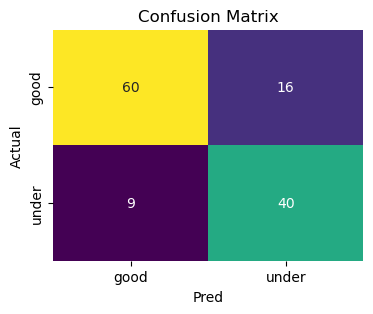

In [144]:
print_scores(pipeline_1,"train")

**TPR = Recall = Sensitivity = TP / (TP + FN)**
* "Of all the actually positive cases, how many did we get correct"?
    * True Positive Rate

**Precision = TP / (TP + FP)**
* "Of all of the things the model predicted as positive cases, how many were actually positive?"
    * Positive Predicted Value

### Training Score

In [145]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
print(cross_val_score(pipeline_1, X_train, y_train, cv=rkf, scoring="roc_auc").mean())

0.8477444444444445


# Feature Selection for Optimization

In [146]:
feature_importance = pipeline_1.named_steps['classifier'].coef_[0]
feature_names = predictors_num
importance_df = pd.DataFrame({'feature': feature_names, 'importance': abs(feature_importance)})
importance_df.sort_values('importance', ascending=False)

,feature,importance
5,slope_width,1.462268
8,delta_hue,1.387843
6,jitter_cx,1.131397
1,continuity,0.715771
4,amp_width,0.671247
10,pull_duration_s,0.599213
2,mean_width,0.366861
3,cv_width,0.362769
7,delta_val,0.346238
9,flicker,0.288154


The above values are the absolute slope coefficients for the decision boundary

In [147]:
df["true_label"].value_counts()

true_label
good     95
under    62
Name: count, dtype: int64

# ROC Curve - Train

ROC Curve plots TPR (recall) against FPR. 

In [148]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

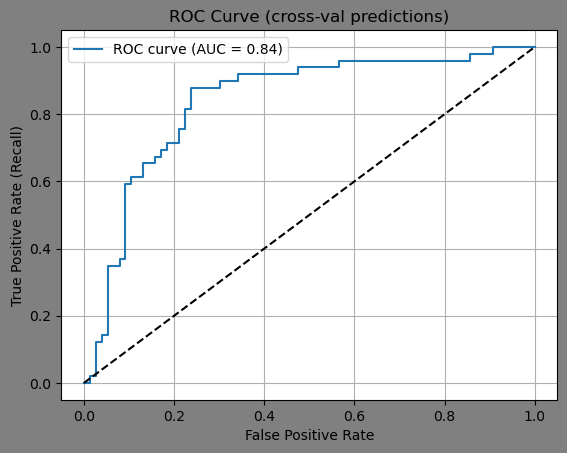

In [149]:
proba = pipeline_1.predict_proba(X_train)[:,1] # the [:,1] means get all rows of column 1, which corresponds to under
pred  = (proba >= 0.5).astype(int) #we can choose the threshold

#1. predict_proba_method
y_scores_proba = cross_val_predict(pipeline_1,X_train,y_train,cv=5,method="predict_proba")[:,1] #take all rows of class 1 positive

#2. pass true labels into roc_curv
fpr, tpr, thresholds = roc_curve(y_train,y_scores_proba)
roc_auc = roc_auc_score(y_train,y_scores_proba)

plt.figure(facecolor='gray') 
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], "k--")  # random baseline for the classifier
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (cross-val predictions)")
plt.legend()
plt.grid()
plt.show()

What is ROC doing statistically?

- You have a score for each shot (probability of under). That is proba
- You can pick any threshold to turn that into yes/no, which gives us pred
- ROC asks: "Across all possible thresholds, how good is my model at ranking true under shots above true good shoots.?"

**ROC measures seperability** . Are the distributions for under vs good pulled apart and distinguished?

It tells you how well your model separates the two classes, independent of threshold, and shows the trade-off between sensitivity (catching “under” correctly - TPR) and specificity (not crying wolf on catching “good” - FPR).

What is Precision-Recall Curve doing statistically?

- We have our score and our prediction from that probability. Same as before
- PR asks: "Across all possible thresholds, how good is my model at balancing catching true under shots without flooding the system with false positives?"

**PR tells you how trustworthy the model's "under" calls are**

PR curve measures the trade-off between recall (catching unders) and precision (being correct when you say under), across all thresholds.

In [150]:
################################################################################################################

# Model 2: Random Forest Classifier --> Pipeline

In [151]:
from sklearn.ensemble import RandomForestClassifier

In [152]:
pipeline_2 = Pipeline([
    ("imputer",SimpleImputer(strategy="median")), #just in case
    ("classifier",RandomForestClassifier(
        n_estimators=300,                   # more trees --> smoother prob. 
        min_samples_split=4,                # 4 samples at a node to split        
        min_samples_leaf=2,                 # and at least 2 samples in each leaf after splitting
        n_jobs=-1,                          # run in parallel 
        random_state=42,
        class_weight="balanced"
        ))
])

pipeline_2.fit(X_train,y_train)

,steps,"[('imputer', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,n_estimators,300


Why does Random Forest not need StandardScaler? It's because decision trees just make thresholds and rank based on ordering and comparisons. Scaling won't matter. 

On the other hand, Logistic Regression, SVM, and others need scaling because they look at feature magnitude and weights. 

In [153]:
proba_forest = pipeline_2.predict_proba(X_train)[:,1] 
pred_forest  = (proba_forest >= 0.5).astype(int)

# Training Scores - Model 2 

TRAIN ROC-AUC: 1.0
TRAIN PR-AUC : 1.0
              precision    recall  f1-score   support

        good       1.00      0.99      0.99        76
       under       0.98      1.00      0.99        49

    accuracy                           0.99       125
   macro avg       0.99      0.99      0.99       125
weighted avg       0.99      0.99      0.99       125

TRAIN accuracy 0.992


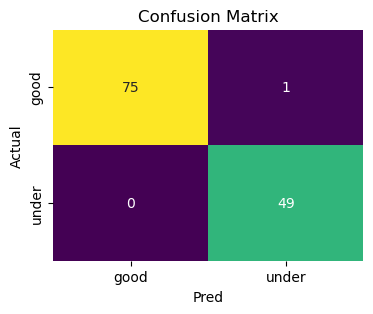

In [154]:
print_scores(pipeline_2,"train")

That is too good to be true so no

In [155]:
rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
print(cross_val_score(pipeline_2, X_train, y_train, cv=rkf, scoring="roc_auc").mean())

0.8503888888888889


### ROC Curve

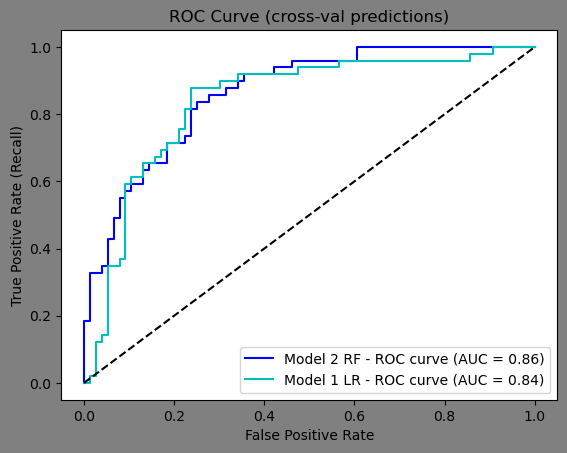

In [156]:
#1. predict_proba_method
y_scores_proba_forest = cross_val_predict(pipeline_2,X_train,y_train,cv=5,method="predict_proba")[:,1] #take all rows of class 1

#2. pass true labels into roc_curv
fpr_forest, tpr_forest, thresholds = roc_curve(y_train,y_scores_proba_forest)
roc_auc_forest = roc_auc_score(y_train,y_scores_proba_forest)

plt.figure(facecolor='gray') 
plt.plot(fpr_forest, tpr_forest,"b-", label=f"Model 2 RF - ROC curve (AUC = {roc_auc_forest:.2f})")
plt.plot(fpr, tpr, "c-",label=f"Model 1 LR - ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], "k--")  # random baseline for the classifier
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (cross-val predictions)")
plt.legend()
plt.show()

Strange. Very strange indeed

Well okay let's follow the book's advice. The books says that if False Positives are a big deal, we should look at PR. 

### PR Curve

In [157]:
from sklearn.metrics import precision_recall_curve

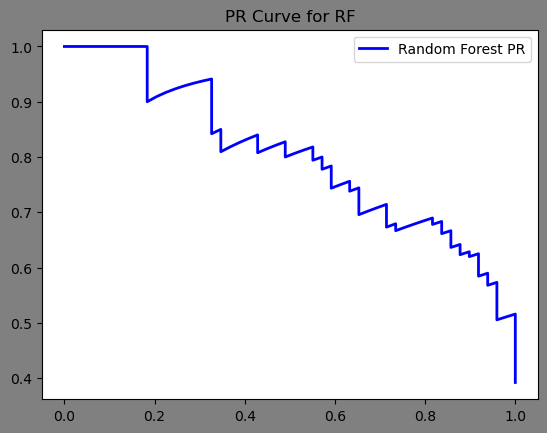

In [158]:
precisions_forest , recalls_forest, thresholds_forest = precision_recall_curve(y_train,y_scores_proba_forest)

plt.figure(facecolor='gray') 
plt.plot(recalls_forest,precisions_forest,"b-",linewidth=2,label="Random Forest PR")
plt.title("PR Curve for RF")
plt.legend()
plt.show()

Computing f1 at each threshold. Ultimately, let's find the threshold that balances precision and recall

In [159]:
f1s = 2 * (precisions_forest * recalls_forest) / (precisions_forest + recalls_forest + 1e-6)
best_idx = np.argmax(f1s)
best_thresh = thresholds_forest[best_idx]

print("Best Threshold for RF:",best_thresh)
print("Best F1-Score for RF:",f1s[best_idx])
print("Precision:",precisions_forest[best_idx])
print("Recall:",recalls_forest[best_idx])

Best Threshold for RF: 0.42491264208568663
Best F1-Score for RF: 0.752293083074141
Precision: 0.6833333333333333
Recall: 0.8367346938775511


# Model 3 : RSCV

In [160]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold, GridSearchCV

In [161]:
pipeline_3 = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(class_weight="balanced",n_jobs=-1,random_state=42)),
])

param_dist = {
    "clf__n_estimators": [200, 300, 500],
    "clf__max_depth": [None, 8],          # None is often fine; shallow can help stability
    "clf__min_samples_split": [2, 4, 5],
    "clf__min_samples_leaf": [2, 3, 4],
    "clf__max_features": ["sqrt", None],     # try smaller feature subsampling
}

cv_strat = RepeatedStratifiedKFold(n_splits=5,n_repeats=5,random_state=42)

search = GridSearchCV(
    pipeline_3,
    param_grid=param_dist,
    cv=cv_strat,
    scoring="average_precision",
    n_jobs=-1
)

search.fit(X_train,y_train)

print("Best params:", search.best_params_)
print("Best score:", search.best_score_)
best_rf = search.best_estimator_

Best params: {'clf__max_depth': None, 'clf__max_features': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 500}
Best score: 0.8010608757599469


80.1% average precision score is not too bad

In [162]:
# get CV out-of-fold probs to choose threshold. 0.5 is too rigid

y_scores_search = cross_val_predict(best_rf, X_train, y_train, cv=5, method="predict_proba")[:,1]
prec, rec, thr = precision_recall_curve(y_train, y_scores_search)
roc_auc_search = roc_auc_score(y_train,y_scores_search)
# pick threshold you like (max F1, or target precision/recall)

f1s = 2 * (prec * rec) / (prec + rec + 1e-6)
best_idx = np.argmax(f1s)
best_thresh = thr[best_idx]

print("Best Threshold for RF:",best_thresh)
print("Best F1-Score for RF:",f1s[best_idx])
print("Precision:",prec[best_idx])
print("Recall:",rec[best_idx])
print("ROC AUC Score",roc_auc_search)

Best Threshold for RF: 0.5184344221378734
Best F1-Score for RF: 0.7647053831222023
Precision: 0.7358490566037735
Recall: 0.7959183673469388
ROC AUC Score 0.8678839957035446


In [163]:
# See how it performs on unseen data
y_test_proba = best_rf.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= best_thresh).astype(int)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Test set results:")
print(classification_report(y_test, y_test_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("Accuracy Score")
print(accuracy_score(y_test,y_test_pred))

Test set results:
              precision    recall  f1-score   support

           0       0.72      0.95      0.82        19
           1       0.86      0.46      0.60        13

    accuracy                           0.75        32
   macro avg       0.79      0.70      0.71        32
weighted avg       0.78      0.75      0.73        32


Confusion Matrix:
[[18  1]
 [ 7  6]]
Accuracy Score
0.75


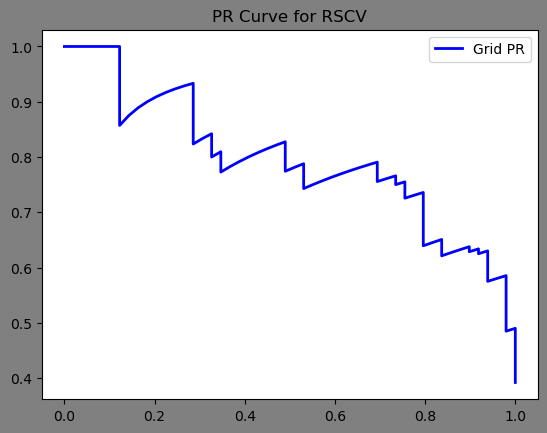

In [164]:
plt.figure(facecolor='gray') 
plt.plot(rec,prec,"b-",linewidth=2,label="Grid PR")
plt.title("PR Curve for RSCV")
plt.legend()
plt.show()

In [165]:
print("Test ROC AUC Grid",roc_auc_score(y_test,y_test_proba))

Test ROC AUC Grid 0.9149797570850202


That is actually pretty damn good ngl

Ultimate goal is to get 90+% for ROC, 80+% AVG PRec score, and any higher accuracy score is better. 